## Imoprting

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fuzzywuzzy import fuzz,process
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor,\
                            GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression,SGDRegressor, Ridge, Lasso
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore")

## Exploring

In [88]:
train = pd.read_csv('train.csv')
train_copy = train.copy()
test = pd.read_csv('test.csv')
print(train.shape)
train.head()

(7000, 15)


,ID,Brand,VehicleModel,ManufacturingYear,Type,rating,color,Duty,fuel,CylinderCount,type of gear,capacity,Odometer,#airbags,price
0,2624,NaN,I have the fastest model ever.. yes you got it...,2017,WOOW Sedan,0.0,NaN,I had to pay a substantial $1249 levy on my ne...,Gas,4.0,R,2.5,75492 KM,1008,21012
1,14392,I love TOYOTA,NaN,NaN,Minivan3,5.0,Metallic,-,Gas,4.0 cyl,R,2.4,220000 KM,-96,11917
2,9822,hyundai,H1,2009,MINIVAN,0.0,Metallic,1185$,Dies,4.0,R,2.5,TOTAL 50653 km,4 count,22433
3,17123,opel,Corsa,NaN,Hatchback,5.0,Jet Black,-,NaN,4.0,auto,0,230000 KM,0,5645
4,11133,subaru,I own Outback.,2007,Hatchback,4.0,Sapphire Blue,-,Gas,4.0,NaN,2.5,131000 KM,4,10976


In [4]:
train.isnull().sum()

ID                      0
Brand                 706
VehicleModel          697
ManufacturingYear     695
Type                  685
rating                690
color                2124
Duty                    0
fuel                  696
CylinderCount           0
type of gear          692
capacity                0
Odometer                0
#airbags                0
price                   0
dtype: int64

In [5]:
train.describe()

,ID,rating,price
count,7000.000000,6310.000000,7000.000000
mean,9022.128714,2.559588,14406.866429
std,5202.316292,1.905482,11747.617978
min,1.000000,-4.000000,3.000000
25%,4546.750000,1.000000,5018.000000
50%,9044.500000,2.000000,12544.000000
75%,13523.250000,4.000000,20071.000000
max,18013.000000,10.000000,49889.000000


In [6]:
train.describe(include='object')

,Brand,VehicleModel,ManufacturingYear,Type,color,Duty,fuel,CylinderCount,type of gear,capacity,Odometer,#airbags
count,6294,6303,6305,6315,4876,7000,6304,7000,6308,7000,7000,7000
unique,185,1480,555,81,16,1173,7,28,7,87,4964,321
top,toyota,Prius,2012,sedan,Jet Black,-,Gas,4.0,auto,2,0 km,12
freq,497,113,429,1160,1239,2108,3272,2638,2870,1261,79,830


### Check for duplicates

In [7]:
train.duplicated(subset='ID').sum()

0

### Check for Nulls

In [8]:
null =pd.DataFrame(train.isnull().sum(),columns=['No. null'])
presentage = pd.DataFrame(train.isnull().sum()/train.shape[0]*100,columns=['% null'])
null = null.join(presentage)
null

,No. null,% null
ID,0,0.000000
Brand,706,10.085714
VehicleModel,697,9.957143
ManufacturingYear,695,9.928571
Type,685,9.785714
rating,690,9.857143
color,2124,30.342857
Duty,0,0.000000
fuel,696,9.942857
CylinderCount,0,0.000000


## Tasks
### From easy to hard
We need to clean:
- 1 Rating ✅
- 2 capacity ✅
- 3 #airbags ✅ -Note- Don't Delete outlires!
- 4 color ✅
- 5 fuel ✅
- 6 type of gear ✅
- 7 CylinderCount ✅
- 8 Type ✅
- 9 Odometer ✅
- 10 ManufacturingYear ✅
- 11 Brand ✅
- 12 Duty ✅
- 13 VehicleModel ✅

## Cleaning

### Rename cols

In [9]:
train.rename(columns={'#airbags': 'airbags',
                      'type of gear': 'gearType'}, inplace=True)

### Convert all object cols to string to avoid any errors

In [10]:
object_cols = train.select_dtypes(include='object').columns
train[object_cols] = train[object_cols].astype(str)

### Cleaning Type Column

In [11]:
train.Type.value_counts()

Type
sedan         1160
SEDAN          850
jeep           691
nan            685
JEEP           501
              ... 
Pickup1          1
Universal4       1
Coupe2           1
Pickup3          1
Pickup0          1
Name: count, Length: 82, dtype: int64

In [12]:
def clean_Type(TypeCol):
    TypeCol = TypeCol.str.lower()
    TypeCol = TypeCol.str.strip()
    list_of_mapping = ['sedan', 'minivan', 'hatchback', 'pickup', 'jeep', 'microbus', 'coupe', 'universal', 'goods wagon', 'cabriolet', 'limousine']
    
    def clean_value(value, standard_values, threshold=80):
        if pd.isna(value):
            return value
        best_match = process.extractOne(value, standard_values, scorer=fuzz.token_sort_ratio)
        if best_match[1] >= threshold:
            return best_match[0]
        return value
    
    TypeCol = TypeCol.apply(lambda x: clean_value(x, list_of_mapping))
    TypeCol = TypeCol.str.replace('woow ', '')
    return TypeCol


In [13]:
train['Type'] = clean_Type(train['Type'])


In [14]:
train.Type.value_counts()

Type
sedan          2907
jeep           1706
hatchback       989
nan             685
minivan         240
coupe           153
universal       107
microbus        101
goods wagon      87
pickup           14
cabriolet         9
limousine         2
Name: count, dtype: int64

### Cleaning capacity

In [15]:
train.capacity.unique()

array(['2.5', '2.4', '0', '2', '5', '3', '1.3', '1.5', '1.6', '1.8',
       '3.5', '2.7 Turbo', '1.8 Turbo', '2.7', '2.5 Turbo', '3.3', '1.7',
       '2.2', '2.2 Turbo', '4', '1.4', '4.8', '1.2', '2.3', '1.6 Turbo',
       '4.7', '2.0 Turbo', '2.8 Turbo', '3.2', '5.5', '6.2', '4.6', '3.7',
       '1', '3.0 Turbo', '1.9 Turbo', '2.4 Turbo', '5.0 Turbo', '3.6',
       '4.4', '1.4 Turbo', '2.6', '3.2 Turbo', '0.6 Turbo', '1.5 Turbo',
       '6.3', '3.8', '5.7', '1.9', '4.5', '5.9', '0.3', '5.5 Turbo',
       '4.5 Turbo', '4.2', '3.5 Turbo', '0.4', '0.1', '0.2', '0.8',
       '4.4 Turbo', '2.3 Turbo', '4.7 Turbo', '2.9 Turbo', '1.7 Turbo',
       '6.7', '2.1 Turbo', '2.8', '2.9', '0.7', '2.1', '1.3 Turbo', '5.4',
       '5.4 Turbo', '3.4', '5.3', '4.3', '0.9', '0.8 Turbo', '0.6',
       '3.6 Turbo', '1.0 Turbo', '5.6', '5.2', '1.1', '4.8 Turbo', '0.5'],
      dtype=object)

In [16]:
train.capacity = train.capacity.astype('category')

### Cleaning #airbags

In [17]:
train.airbags.unique()

array(['1008', '-96', '4 count', '0  ', '4  ', '12', '6 count', '8', '4',
       '12,', '6~', '106', '6', '2', '8 bags', '12<', '0',
       'ONLY 10 AIRBAG', '12 count', 'ONLY 4 AIRBAG', '1012', '10',
       '12 bags', '4 bags', 'ONLY 8 AIRBAG', '5', '8 count',
       'ONLY 0 AIRBAG', '12/', 'ONLY 6 AIRBAG', '12)', '-100', '8=',
       'ONLY 12 AIRBAG', '12  ', '108', '4<', '-94', '12|', '6 bags',
       '2 count', '12`', '4]', '8$', '-88', '10 count', '6  ', '12>',
       '112', '6(', '11', '110', '4@', '4&', '0 count', '4{', '4#', '104',
       '1005', '12~', '4!', '2  ', '5 count', '16 bags', '6?', '1', '-92',
       '100', '1004', '9', '14', '4$', '4,', '12!', '8  ', '-90', '12&',
       '6/', '1 count', 'ONLY 2 AIRBAG', '0~', "8'", '2 bags', '4[',
       '10 bags', '8&', '0 bags', '12#', "4'", '2<', '0#', "0'", '13',
       '2(', '2*', '4"', '4(', '0-', '8:', '2,', '8@', 'ONLY 5 AIRBAG',
       '-98', '4_', '0"', '0[', '10  ', '7', '12}', '1002', '6"', '6_',
       '6:', '4;', '10

In [18]:
train.airbags.dtype

dtype('O')

In [19]:
# Replace the non-numeric characters in the airbags column with an empty string
train['airbags'] = train['airbags'].str.replace(r'\D', '', regex=True).astype(int)


In [20]:
train.airbags.describe()

count    7000.000000
mean       45.664429
std       178.772417
min         0.000000
25%         4.000000
50%         6.000000
75%        12.000000
max      1016.000000
Name: airbags, dtype: float64

In [21]:
train.airbags.value_counts()

airbags
4       1870
12      1852
0        774
8        545
6        455
2        357
10       270
96        78
1012      77
88        69
104       60
100       59
112       57
1004      52
5         34
1         33
7         30
16        27
1000      25
1008      24
108       23
1002      22
106       22
98        21
9         19
92        18
94        17
11        16
90        13
1010      12
1006      11
3         11
110       10
102        9
14         7
1007       4
15         2
1005       2
116        2
13         2
99         1
105        1
1016       1
101        1
111        1
97         1
107        1
109        1
95         1
Name: count, dtype: int64

<Axes: xlabel='airbags'>

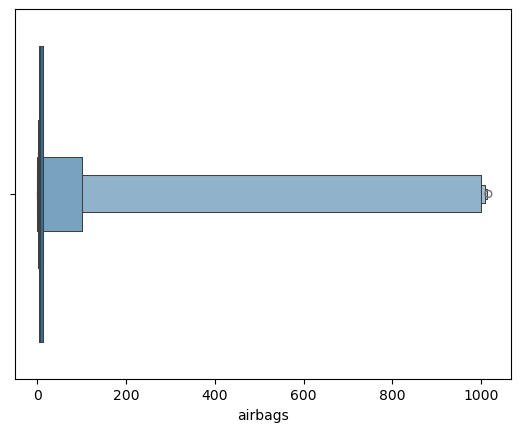

In [22]:
sns.boxenplot(x=train.airbags)

In [23]:
train[train.airbags == 12].groupby('Type')["airbags"].value_counts()


Type         airbags
cabriolet    12           3
coupe        12          37
goods wagon  12           2
hatchback    12         154
jeep         12         483
minivan      12          11
nan          12         174
pickup       12           4
sedan        12         980
universal    12           4
Name: count, dtype: int64

In [24]:
mean_price = train[train.airbags == 12].groupby('Type')["price"].mean()
mean_price

Type
cabriolet      16726.000000
coupe          10434.621622
goods wagon    10662.500000
hatchback       8267.961039
jeep           11494.523810
minivan        20598.363636
nan            10059.206897
pickup         20502.000000
sedan           9934.785714
universal      30576.750000
Name: price, dtype: float64

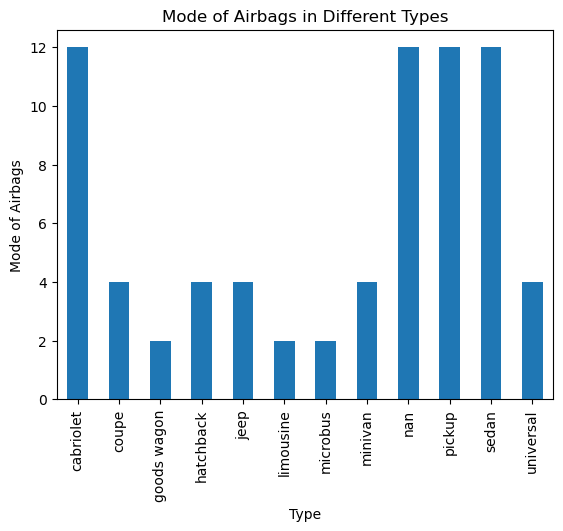

In [25]:
mode_airbags = train.groupby('Type')['airbags'].apply(lambda x: x.mode()[0])
mode_airbags.plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Mode of Airbags')
plt.title('Mode of Airbags in Different Types')
plt.show()

There is a lot of outliers here, actually, there is no cars have more than 12 airbags in the world!

In [26]:
train.loc[(train['airbags'] > 12) | (train['airbags'] <= 0), 'airbags'] = 4

<Axes: xlabel='airbags'>

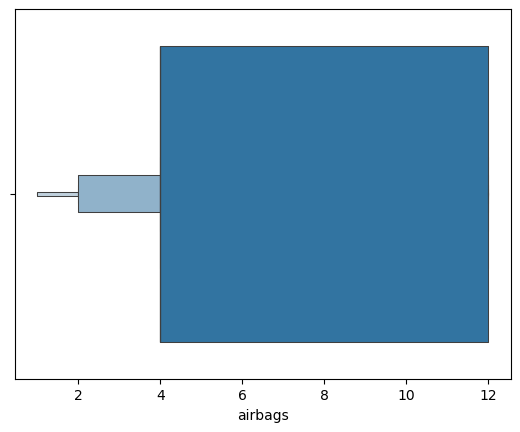

In [27]:
sns.boxenplot(x=train.airbags)

Now that's better :)

### Cleaning color

In [28]:
train.color.value_counts()

color
nan              2124
Jet Black        1239
Pearl White      1083
Metallic          995
Charcoal          628
Sapphire Blue     371
Crimson           166
Emerald Green      77
Tangerine          66
Gold               49
Chocolate          47
Ruby Red           44
Sky Blue           35
Sand               34
Lemon Yellow       30
Royal Purple        7
Rose Pink           5
Name: count, dtype: int64

Everything alright here

### Cleaning fuel

In [29]:
train.fuel.value_counts()

fuel
Gas                3272
Dies               1291
Electric Hybrid    1250
nan                 696
other               307
Natural Gas         157
hyb                  26
others                1
Name: count, dtype: int64

In [30]:
maps = {"others": "other",
       "Natural Gas":"Gas",
       'Electric Hybrid': 'Hybrid',
       "hyb": "Hybrid"}
train.fuel = train.fuel.replace(maps)

In [31]:
train.fuel.value_counts()

fuel
Gas       3429
Dies      1291
Hybrid    1276
nan        696
other      308
Name: count, dtype: int64

### Cleaning gearType

In [32]:
train.gearType.value_counts()

gearType
auto      2870
others    1228
nan        692
gear       639
R          635
AUTO       553
manual     320
MANUAL      63
Name: count, dtype: int64

In [33]:
train.gearType = train.gearType.str.lower()
train.gearType.replace('r', 'manual', inplace=True)
train.gearType.replace('gear', 'manual', inplace=True)
train.gearType.value_counts()

gearType
auto      3423
manual    1657
others    1228
nan        692
Name: count, dtype: int64

### Cleaning CylinderCount

In [34]:
train.CylinderCount.value_counts()

CylinderCount
4.0         2638
4.0 cyl     1631
0            718
6.0          627
14.0         525
6.0 cyl      344
8.0          161
16.0         107
8.0 cyl       94
5.0           29
18.0          26
5.0 cyl       19
3.0           16
3.0 cyl       12
12.0           8
2.0            7
1.0            7
15.0           6
2.0 cyl        6
12.0 cyl       4
1.0 cyl        3
10.0           3
16.0 cyl       2
11.0           2
7.0            2
10.0 cyl       1
13.0           1
9.0            1
Name: count, dtype: int64

In [35]:
# delete word "cyl" 
train.CylinderCount = train.CylinderCount.apply(lambda x: x.replace('cyl',''))
train.CylinderCount = train.CylinderCount.str.strip()
train.CylinderCount = train.CylinderCount.astype(float)

# Replace 0 Values with NaN
train.loc[train.CylinderCount == 0, 'CylinderCount'] = np.nan
train.CylinderCount.value_counts()

CylinderCount
4.0     4269
6.0      971
14.0     525
8.0      255
16.0     109
5.0       48
3.0       28
18.0      26
2.0       13
12.0      12
1.0       10
15.0       6
10.0       4
11.0       2
7.0        2
9.0        1
13.0       1
Name: count, dtype: int64

### Cleaning Odometer

In [36]:
train.Odometer.unique()

array(['75492 KM', '220000 KM', 'TOTAL 50653 km', ..., '156802  kilo',
       '314373 KM', '131627'], dtype=object)

In [37]:
train.Odometer = train.Odometer.str.replace(r'\D', '', regex=True).astype(float)
train.Odometer.describe()

count    7.000000e+03
mean     1.589344e+06
std      5.018431e+07
min      0.000000e+00
25%      7.453000e+04
50%      1.291280e+05
75%      1.904135e+05
max      2.147484e+09
Name: Odometer, dtype: float64

### Cleaning Duty

In [38]:
train.Duty.unique()

array(['I had to pay a substantial $1249 levy on my new car purchase.',
       '-', '1185$', ..., '2909$',
       'The car levy amounted is 893 per vehicle.', '965'], dtype=object)

In [39]:
train.Duty.describe()

count     7000
unique    1173
top          -
freq      2108
Name: Duty, dtype: object

In [40]:
train.Duty = train.Duty.str.strip()
train.Duty.replace('-', np.nan, inplace=True)
train.Duty = train.Duty.str.replace(r'\D', '', regex=True)

# Replace empty strings with NaN
train['Duty'] = train['Duty'].replace(r'^\s*$', np.nan, regex=True).astype(float)

### Cleaning Brand

In [41]:
train.Brand.value_counts()

Brand
nan                   706
toyota                497
hyundai               486
TOYOTA                370
HYUNDAI               364
                     ... 
SCION                   1
ROLLS-ROYCE             1
DAEWOO is the best      1
I love CITROEN          1
Jaguar                  1
Name: count, Length: 186, dtype: int64

In [42]:
train['Brand'] = train['Brand'].str.lower()
train['Brand'] = train['Brand'].str.replace('i love ', '')
train['Brand'] = train['Brand'].str.replace(' is the best', '')
train.Brand.value_counts()

Brand
toyota           1246
hyundai          1225
nan               706
mercedes-benz     651
chevrolet         362
ford              353
bmw               333
honda             325
lexus             279
nissan            216
volkswagen        194
ssangyong         163
kia               155
opel              139
subaru            105
mitsubishi         96
audi               78
mazda              61
jeep               44
fiat               30
dodge              30
daewoo             30
suzuki             24
renault            13
jaguar             12
porsche            11
mini               11
vaz                11
lincoln            10
land rover          9
skoda               7
peugeot             7
volvo               7
infiniti            7
buick               6
daihatsu            5
uaz                 5
gaz                 4
chrysler            3
citroen             3
scion               3
cadillac            3
acura               2
moskvich            2
alfa romeo          2
gmc 

In [43]:
train.loc[train['Brand'] == 'სხვა', 'Brand'] = 'gac'


### Cleaning model

In [44]:
train.VehicleModel.value_counts()

VehicleModel
nan                      697
Prius                    113
Sonata                   104
Elantra                   96
FIT                       96
                        ... 
Mazda 6 Grand Touring      1
I own Clio.                1
500 Abarth                 1
I own Quest.               1
I own X-type.              1
Name: count, Length: 1481, dtype: int64

In [45]:
train.VehicleModel = train.VehicleModel.str.lower()
to_remove = ["i have the fastest model ever.. yes you got it right it's ", "my model which is ", " is the best", "i own " ]
for i in to_remove:
    train["VehicleModel"] = train["VehicleModel"].str.replace(i, "")

# for removing trailing dots
train["VehicleModel"] = train["VehicleModel"].str.replace('.', "")

# for removing non-ascii characters
train["VehicleModel"] = train["VehicleModel"].str.replace(r'[^\x00-\x7F]', '', regex=True).str.strip()
train.VehicleModel = train.VehicleModel.astype(str)

# keep the first word only if it contains more then 1 word
train.VehicleModel = train.VehicleModel.apply(lambda x: x.split()[0] if len(x.split()) > 1 else x)
train.VehicleModel = train.VehicleModel.replace('nan', pd.NA)

In [46]:
train.VehicleModel.value_counts()

VehicleModel
prius       437
sonata      369
camry       341
elantra     329
e           255
           ... 
coltplus      1
rasheen       1
stella        1
c8            1
x-type        1
Name: count, Length: 429, dtype: int64

### Cleaning ManufacturingYear

In [47]:
list_of_unique = train.ManufacturingYear.unique()
list_of_unique

array(['2017', 'nan', '2009', '2007', '3010', '1999', '2012', '2011',
       '2014', '2015', '2006', '2105', '2013,', '2010', '2017{',
       '1-1-2003', '2016', '1998', '2018', '2008', '2015+', '2012"',
       '2013', '2111', '1-1-2020', '2005', '2017*', '2004', '2016.',
       '2015#', '1910', '2017&', '1914', '1-1-2013', '3009', '2009&',
       '2018}', '14years old', '1-1-2014', '2001', '2015`', '2112',
       '1997', '2014@', '1917', '2014+', '2013*', '1-1-2011', '1-1-2008',
       '2012,', '2003', '1-1-2007', '15years old', '1916', '1-1-2012',
       '1912', '2010~', '2020', '2002>', '2110', '2005>', '2115',
       '1-1-2005', '2009%', '2019', '10years old', '1-1-2002', '2015@',
       '3013', '1907', '2010*', '2000', '1996_', '12years old', '2011;',
       '2017_', '13years old', '3014', '2017(', '2011,', '11years old',
       '7years old', '1-1-2010', '3004', '1996|', '1913', '2014|',
       '1-1-2016', '2016[', '1900', "2009'", '1902', '2117', '1-1-2009',
       '8years old', 

In [48]:
# 04-30-2020
rows = train[train.ManufacturingYear.str.contains('years old', case=False, na=False)]
# Replace "years old" with an empty string
rows.ManufacturingYear = rows.ManufacturingYear.str.replace('years old' ,"" ).astype('int')
rows.ManufacturingYear = 2024 - rows.ManufacturingYear
train.update(rows)
rows = train[train.ManufacturingYear.str.contains('-', case=False, na=False)]
# Split the string by '-' and keep the last element "Year"
rows.ManufacturingYear = rows.ManufacturingYear.str.split('-').apply(lambda x : x[-1])
train.update(rows)
train['ManufacturingYear'] = train['ManufacturingYear'].str.replace(r'\D', '', regex=True)
train['ManufacturingYear'] = pd.to_numeric(train['ManufacturingYear'] ,errors='coerce')

In [49]:
train['ManufacturingYear'].value_counts().sort_index()

ManufacturingYear
1893.0     1
1895.0     1
1896.0     3
1898.0     4
1900.0     5
          ..
3015.0    21
3016.0    13
3017.0     8
3018.0     4
3019.0     2
Name: count, Length: 116, dtype: int64

There is unexpected values here, like 3019 and 1893

In [50]:
train.loc[train.ManufacturingYear < 1980, 'ManufacturingYear'] += 100
train.loc[train.ManufacturingYear > 3000, 'ManufacturingYear'] -= 1000
train.loc[train.ManufacturingYear > 2024, 'ManufacturingYear'] -= 100

train.loc[train.ManufacturingYear > 2024, 'ManufacturingYear'] = np.nan
train.loc[train.ManufacturingYear < 1980, 'ManufacturingYear'] = np.nan

In [51]:
train['ManufacturingYear'].value_counts().sort_index()

ManufacturingYear
1982.0      1
1983.0      3
1984.0      1
1985.0      2
1986.0      1
1987.0      2
1988.0      3
1989.0      1
1990.0      6
1991.0      3
1992.0     15
1993.0      7
1994.0     11
1995.0     36
1996.0     28
1997.0     41
1998.0     65
1999.0     57
2000.0     85
2001.0     72
2002.0     97
2003.0    119
2004.0    114
2005.0    118
2006.0    104
2007.0    151
2008.0    232
2009.0    170
2010.0    467
2011.0    514
2012.0    642
2013.0    587
2014.0    638
2015.0    432
2016.0    380
2017.0    245
2018.0    112
2019.0     66
2020.0      9
Name: count, dtype: int64

In [52]:
train.describe(include='object')

,Brand,VehicleModel,Type,color,fuel,gearType
count,7000,6303,7000,7000,7000,7000
unique,55,429,12,17,5,4
top,toyota,prius,sedan,nan,Gas,auto
freq,1246,437,2907,2124,3429,3423


In [53]:
train.describe()

,ID,ManufacturingYear,rating,Duty,CylinderCount,Odometer,airbags,price
count,7000.000000,5637.000000,6310.000000,4422.000000,6282.000000,7.000000e+03,7000.000000,7000.000000
mean,9022.128714,2010.710662,2.559588,1835.184306,5.602674,1.589344e+06,6.719000,14406.866429
std,5202.316292,5.353890,1.905482,2823.558215,3.270880,5.018431e+07,3.592635,11747.617978
min,1.000000,1982.000000,-4.000000,87.000000,1.000000,0.000000e+00,1.000000,3.000000
25%,4546.750000,2009.000000,1.000000,640.000000,4.000000,7.453000e+04,4.000000,5018.000000
50%,9044.500000,2012.000000,2.000000,831.000000,4.000000,1.291280e+05,4.000000,12544.000000
75%,13523.250000,2014.000000,4.000000,1211.000000,6.000000,1.904135e+05,12.000000,20071.000000
max,18013.000000,2020.000000,10.000000,12455.000000,18.000000,2.147484e+09,12.000000,49889.000000


## Handling Outliers & NaNs


### ManufacturingYear

<Axes: xlabel='ManufacturingYear'>

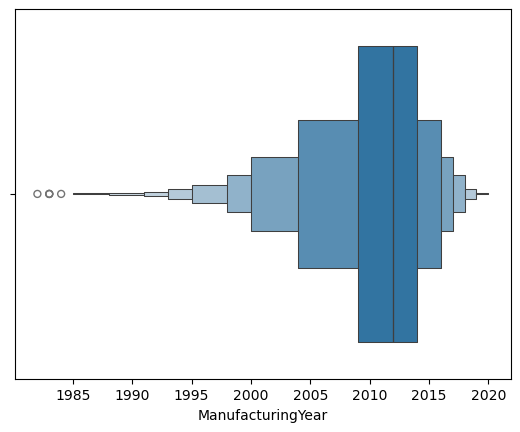

In [54]:
sns.boxenplot(x=train.ManufacturingYear)

In [55]:
train.ManufacturingYear.value_counts()

ManufacturingYear
2012.0    642
2014.0    638
2013.0    587
2011.0    514
2010.0    467
2015.0    432
2016.0    380
2017.0    245
2008.0    232
2009.0    170
2007.0    151
2003.0    119
2005.0    118
2004.0    114
2018.0    112
2006.0    104
2002.0     97
2000.0     85
2001.0     72
2019.0     66
1998.0     65
1999.0     57
1997.0     41
1995.0     36
1996.0     28
1992.0     15
1994.0     11
2020.0      9
1993.0      7
1990.0      6
1983.0      3
1988.0      3
1991.0      3
1985.0      2
1987.0      2
1982.0      1
1986.0      1
1989.0      1
1984.0      1
Name: count, dtype: int64

In [56]:
train.ManufacturingYear.isnull().sum()

1363

In [57]:
train.ManufacturingYear.fillna(train.ManufacturingYear.median(), inplace=True)

In [58]:
train.ManufacturingYear.isnull().sum()

0

### CylinderCount

<Axes: xlabel='CylinderCount'>

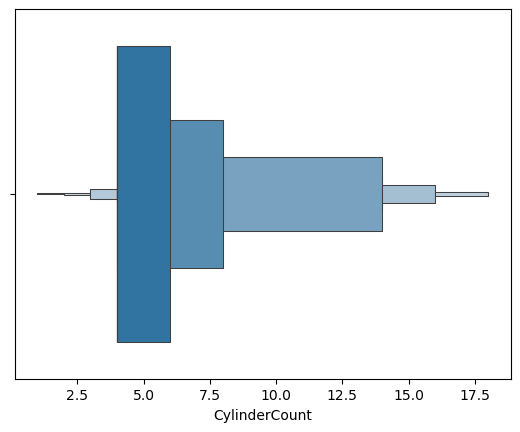

In [59]:
sns.boxenplot(x=train.CylinderCount)

In [60]:
train.CylinderCount.isnull().sum()  

718

In [61]:
train.CylinderCount.fillna(train.CylinderCount.mode()[0], inplace=True)
train.CylinderCount.isnull().sum()  

0

### Model

In [62]:
train.VehicleModel.isnull().sum()

697

In [63]:
def fill_missing_model(train):
    train['VehicleModel'] = train['VehicleModel'].replace('nan', pd.NA)
    to_fill_VehicleModel = train.groupby(['Brand', 'CylinderCount', 'capacity'])['VehicleModel']
    # Fill missing values with the mode of the group
    train['VehicleModel'] = to_fill_VehicleModel.transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'unknown'))
    return train
train = fill_missing_model(train)
train.VehicleModel.isnull().sum()


0

### Brand

In [64]:
def fill_missing_brand(data):
    data['Brand'] = data['Brand'].replace('nan', pd.NA)
    print(data['Brand'].isnull().sum())
    to_fill_brands = data.groupby('VehicleModel')['Brand']

    # Fill missing values with the mode of the group
    data['Brand'] = to_fill_brands.transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'unknown'))
    return data
train = fill_missing_brand(train)
train.Brand.isnull().sum()

706


0

### Types

In [65]:
def fill_missing_types(data):
    data['Type'] = data['Type'].replace('nan', pd.NA)
    print(data['Type'].isnull().sum())
    to_fill_types = data.groupby(['Brand', 'VehicleModel'])['Type']
    data['Type'] = to_fill_types.transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'unknown'))
    return data
train = fill_missing_types(train)
train.Type.isnull().sum()

685


0

### Fuel

In [66]:
# cleaning fuel column
def fill_manipulate_fuel(data):
    # Convert fuel to lowercase
    data['fuel'] = data['fuel'].str.lower()
    
    data['fuel'].replace('nan', pd.NA, inplace=True)
    print(data['fuel'].isnull().sum())
    # Group by 'Brand', 'VehicleModel', and 'Type' and calculate the mode for 'fuel'
    to_fill_fuel = data.groupby(['Brand', 'VehicleModel', 'Type'])['fuel']
    
    # Fill missing values with the mode within each group
    data['fuel'] = to_fill_fuel.transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'other'))
    data['fuel'] = data['fuel'].astype('category')
    return data
train = fill_manipulate_fuel(train)
train.fuel.isnull().sum()

696


0

### airbags

<Axes: xlabel='airbags'>

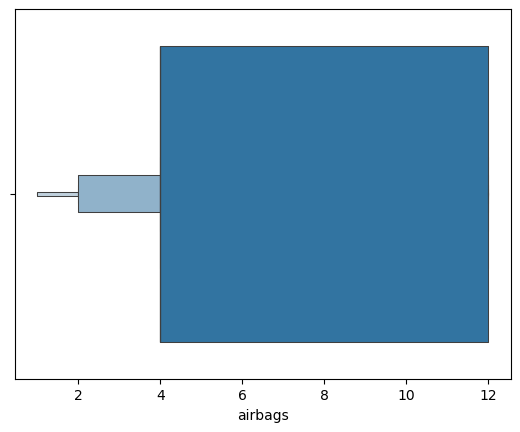

In [67]:
sns.boxenplot(x=train.airbags)

In [68]:
train.airbags.value_counts()

airbags
4     3378
12    1852
8      545
6      455
2      357
10     270
5       34
1       33
7       30
9       19
11      16
3       11
Name: count, dtype: int64

In [69]:
train.airbags.fillna(train.airbags.mode()[0], inplace=True)

### Price

<Axes: xlabel='Type'>

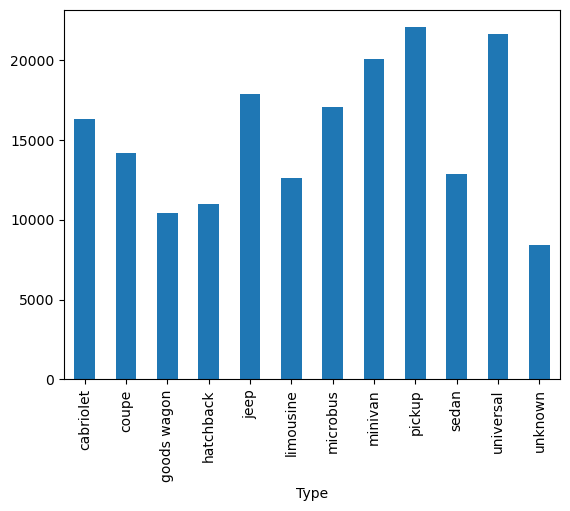

In [70]:
mean_prices_of_cars = train.groupby('Type')['price'].mean()
mean_prices_of_cars.plot(kind='bar')

### rating

In [71]:
train.rating.value_counts()


rating
 2.0     1248
 3.0     1175
 1.0      935
 4.0      925
 0.0      857
 5.0      609
 6.0      274
-1.0      108
 7.0       94
 8.0       35
-2.0       30
-3.0       11
 9.0        7
 10.0       1
-4.0        1
Name: count, dtype: int64

In [72]:
train.rating = abs(train.rating)
train.rating.describe()

count    6310.000000
mean        2.624564
std         1.814927
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        10.000000
Name: rating, dtype: float64

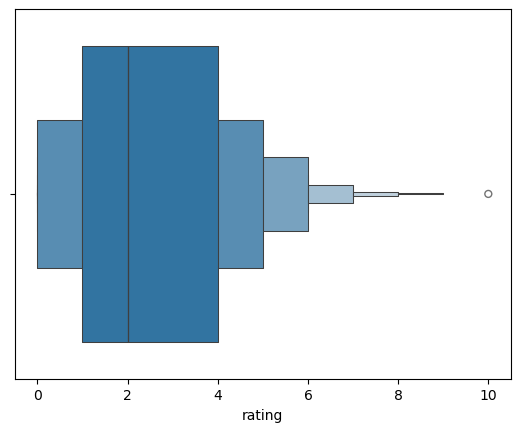

In [73]:
sns.boxenplot(x=train.rating)
plt.show()

In [74]:
train.rating.isnull().sum()

690

### fuel

In [75]:
train.fuel.value_counts()

fuel
gas       3728
dies      1444
hybrid    1444
other      384
Name: count, dtype: int64

### capacity

In [76]:
train.capacity.describe()

count     7000
unique      87
top          2
freq      1261
Name: capacity, dtype: object

In [77]:
train.capacity.isnull().sum()

0

### gearType

In [78]:
train.gearType.value_counts()

gearType
auto      3423
manual    1657
others    1228
nan        692
Name: count, dtype: int64

### Fast Cleaning the rest of columns

In [79]:
# cleaning rating column
train.rating.fillna(train.rating.median(), inplace=True)

# cleaning Duty column
train.Duty.fillna(0, inplace=True)

# cleaning gearType column
train.gearType.fillna('others', inplace=True)

# cleaning airbags column
train.airbags.fillna(train.airbags.mode()[0], inplace=True)

# cleaning color column
train.color.fillna('other', inplace=True)


## Pre-Processing Pipeline 

In [80]:
def cleaning(train):
    for col in train.columns[train.dtypes == 'object']:
        train[col] = train[col].astype('str')
    
    # renaming columns
    train.rename(columns={'#airbags': 'airbags',
                      'type of gear': 'gearType'}, inplace=True)
    
    # cleaning Type column 
    def clean_Type(TypeCol):
        TypeCol = TypeCol.str.lower()
        TypeCol = TypeCol.str.strip()
        list_of_mapping = ['sedan', 'minivan', 'hatchback', 'pickup', 'jeep', 'microbus', 'coupe', 'universal', 'goods wagon', 'cabriolet', 'limousine']
        def clean_value(value, standard_values, threshold=80):
            if pd.isna(value):
                return value
            best_match = process.extractOne(value, standard_values, scorer=fuzz.token_sort_ratio)
            if best_match[1] >= threshold:
                return best_match[0]
            return value
        TypeCol = TypeCol.apply(lambda x: clean_value(x, list_of_mapping))
        TypeCol = TypeCol.str.replace('woow ', '')
        return TypeCol
    train['Type'] = clean_Type(train['Type'])

    # cleaning capacity column
    train.capacity = train.capacity.astype('category')

    # cleaning airbags column
    train['airbags'] = train['airbags'].str.replace(r'\D', '', regex=True).astype(int)
    train['airbags'] = abs(train['airbags'])
    train.loc[(train['airbags'] > 12) | (train['airbags'] <= 0), 'airbags'] = 4

    # cleaning fuel column
    maps = {"others": "other",
       "Natural Gas":"Gas",
       'Electric Hybrid': 'Hybrid',
       "hyb": "Hybrid"}
    train.fuel = train.fuel.replace(maps)

    # cleaning gearType column
    train.gearType = train.gearType.str.lower()
    train.gearType.replace('r', 'manual', inplace=True)
    train.gearType.replace('gear', 'manual', inplace=True)

    # cleaning rating column
    train.rating = abs(train.rating)

    # delete word "cyl" 
    train.CylinderCount = train.CylinderCount.apply(lambda x: x.replace('cyl',''))
    train.CylinderCount = train.CylinderCount.str.strip()
    train.CylinderCount = train.CylinderCount.astype(float)
    train.loc[train.CylinderCount == 0, 'CylinderCount'] = np.nan

    # cleaning Odometer column
    train.Odometer = train.Odometer.str.replace(r'\D', '', regex=True).astype(float)

    # cleaning Duty column
    train.Duty = train.Duty.str.strip()
    train.Duty.replace('-', np.nan, inplace=True)
    train.Duty = train.Duty.str.replace(r'\D', '', regex=True)
    train['Duty'] = train['Duty'].replace(r'^\s*$', np.nan, regex=True).astype(float)

    # cleaning Brand column    
    train['Brand'] = train['Brand'].str.lower()
    train['Brand'] = train['Brand'].str.replace('i love ', '')
    train['Brand'] = train['Brand'].str.replace(' is the best', '')
    train.loc[train['Brand'] == 'სხვა', 'Brand'] = 'gac'

    # cleaning model
    train.VehicleModel = train.VehicleModel.str.lower()
    to_remove = ["i have the fastest model ever.. yes you got it right it's ", "my model which is ", " is the best", "i own " ]
    for i in to_remove:
        train["VehicleModel"] = train["VehicleModel"].str.replace(i, "")

    # for removing trailing dots
    train["VehicleModel"] = train["VehicleModel"].str.replace('.', "")

    # for removing non-ascii characters
    train["VehicleModel"] = train["VehicleModel"].str.replace(r'[^\x00-\x7F]', '', regex=True).str.strip()
    train.VehicleModel = train.VehicleModel.astype(str)

    # keep the first word only if it contains more then 1 word
    train.VehicleModel = train.VehicleModel.apply(lambda x: x.split()[0] if len(x.split()) > 1 else x)
    train.VehicleModel = train.VehicleModel.replace('nan', pd.NA)

    # cleaning ManufacturingYear column
    rows = train[train.ManufacturingYear.str.contains('years old', case=False, na=False)]
    rows.ManufacturingYear = rows.ManufacturingYear.str.replace('years old' ,"" ).astype('int')
    rows.ManufacturingYear = 2024 - rows.ManufacturingYear
    train.update(rows)
    rows = train[train.ManufacturingYear.str.contains('-', case=False, na=False)]
    rows.ManufacturingYear = rows.ManufacturingYear.str.split('-').apply(lambda x : x[-1])
    train.update(rows)
    train['ManufacturingYear'] = train['ManufacturingYear'].str.replace(r'\D', '', regex=True)
    train['ManufacturingYear'] = pd.to_numeric(train['ManufacturingYear'] ,errors='coerce')

    train.loc[train.ManufacturingYear < 1980, 'ManufacturingYear'] += 100
    train.loc[train.ManufacturingYear > 3000, 'ManufacturingYear'] -= 1000
    train.loc[train.ManufacturingYear > 2024, 'ManufacturingYear'] -= 100

    train.loc[train.ManufacturingYear > 2024, 'ManufacturingYear'] = np.nan
    train.loc[train.ManufacturingYear < 1980, 'ManufacturingYear'] = np.nan
    return train

def outlier_and_missing(train, test):

    # cleaning ManufacturingYear column
    train.ManufacturingYear.fillna(train.ManufacturingYear.median(), inplace=True)
    test.ManufacturingYear.fillna(train.ManufacturingYear.median(), inplace=True)

    # cleaning CylinderCount column
    train.CylinderCount.fillna(train.CylinderCount.mode()[0], inplace=True)
    test.CylinderCount.fillna(train.CylinderCount.mode()[0], inplace=True)
    
    # cleaning model column
    def fill_missing_model(train):
        train['VehicleModel'] = train['VehicleModel'].replace('nan', pd.NA)
        to_fill_VehicleModel = train.groupby(['Brand', 'CylinderCount', 'capacity'])['VehicleModel']
        train['VehicleModel'] = to_fill_VehicleModel.transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'unknown'))
        return train
    train = fill_missing_model(train)
    test = fill_missing_model(test)
    
    def fill_missing_brand(data):
        data['Brand'] = data['Brand'].replace('nan', pd.NA)
        to_fill_brands = data.groupby('VehicleModel')['Brand']
        data['Brand'] = to_fill_brands.transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'unknown'))
        return data
    train = fill_missing_brand(train)
    test = fill_missing_brand(test)

    # cleaning Type column
    def fill_missing_types(data):
        data['Type'] = data['Type'].replace('nan', pd.NA)
        to_fill_types = data.groupby(['Brand', 'VehicleModel'])['Type']
        data['Type'] = to_fill_types.transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'unknown'))
        return data
    train = fill_missing_types(train)
    test = fill_missing_types(test)
    
    # cleaning rating column
    train.rating.fillna(train.rating.median(), inplace=True)
    test.rating.fillna(train.rating.median(), inplace=True)

    # cleaning fuel column
    def fill_manipulate_fuel(data):
        # Convert fuel to lowercase
        data['fuel'] = data['fuel'].str.lower()
        
        # Replace 'nan' with actual missing values
        data['fuel'].replace('nan', pd.NA, inplace=True)
        
        # Group by 'Brand', 'VehicleModel', and 'Type' and calculate the mode for 'fuel'
        to_fill_fuel = data.groupby(['Brand', 'VehicleModel', 'Type'])['fuel']
        
        # Fill missing values with the mode within each group
        data['fuel'] = to_fill_fuel.transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'other'))
        data['fuel'] = data['fuel'].astype('category')
        return data
    train = fill_manipulate_fuel(train)
    test = fill_manipulate_fuel(test)

    # cleaning Duty column
    train.Duty.fillna(0, inplace=True)
    test.Duty.fillna(0, inplace=True)

    # cleaning gearType column
    train.gearType.fillna('others', inplace=True)
    test.gearType.fillna('others', inplace=True)
    
    # cleaning airbags column
    train.airbags.fillna(train.airbags.mode()[0], inplace=True)
    test.airbags.fillna(train.airbags.mode()[0], inplace=True)

    # cleaning color column
    train.color.fillna('other', inplace=True)
    test.color.fillna('other', inplace=True)

    return train, test


In [81]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = cleaning(train)
test = cleaning(test)

train, test = outlier_and_missing(train, test)

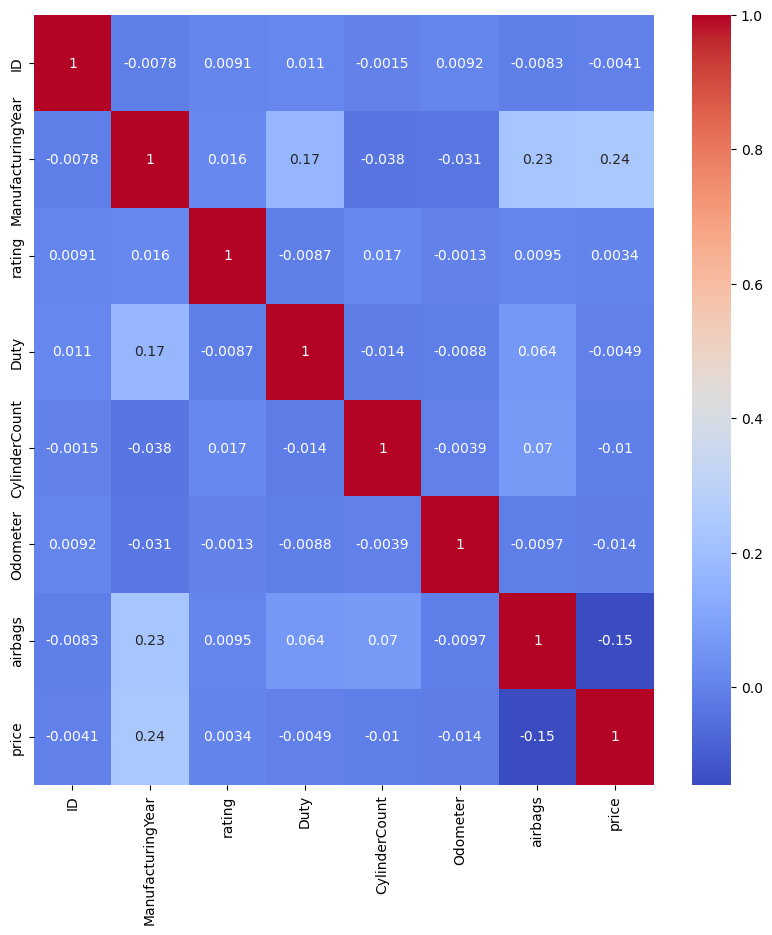

In [82]:
numerical_features = train.select_dtypes(include=['float64', 'int64','int32']).columns.tolist()
correlation = train[numerical_features].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [87]:
# drop unimportant columns
X_train = train.drop(columns=['price','ID', 'color','rating'], axis=1)
y_train = train['price']
X_test = test.drop(columns=['ID', 'color', 'rating'], axis=1)

categorical_features = X_test.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_test.select_dtypes(include=['float64', 'int64','int32']).columns.tolist()
target = 'price'

# Preprocessing
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scalar',StandardScaler(), numerical_features)],
      remainder='passthrough')
X_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)
feature_names = list(column_transformer.named_transformers_['encoder'].get_feature_names_out(input_features=categorical_features)) + numerical_features
X_train_df = pd.DataFrame(X_trans.toarray(), columns=feature_names)
X_test_df = pd.DataFrame(X_test_trans.toarray(), columns=feature_names)
X = X_train_df
y = y_train
X

,Brand_acura,Brand_alfa romeo,Brand_audi,Brand_bmw,Brand_buick,Brand_cadillac,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_daewoo,...,capacity_5.7,capacity_5.9,capacity_6.2,capacity_6.3,capacity_6.7,ManufacturingYear,Duty,CylinderCount,Odometer,airbags
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.249882,0.037181,-0.458597,-0.030168,-0.756880
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.214918,-0.480602,-0.458597,-0.027288,-0.756880
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.406061,0.010649,-0.458597,-0.030663,-0.756880
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.214918,-0.480602,-0.458597,-0.027089,-0.756880
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.820046,-0.480602,-0.458597,-0.029062,-0.756880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.214918,-0.214456,-0.458597,-0.028548,-0.756880
6996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.628903,-0.101282,0.179103,-0.029466,-0.756880
6997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.214918,-0.156832,-0.458597,-0.025408,1.470057
6998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.214918,-0.156832,2.729903,-0.030078,1.470057


## Modeling

### K Nearest Neighboors

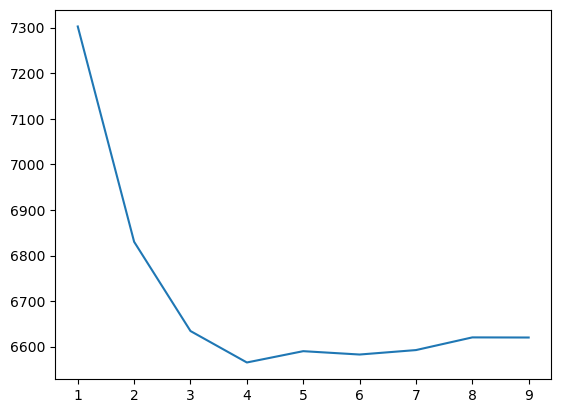

In [84]:
k_scores = []
metric = 'neg_mean_absolute_error'
for k in range(1, 10):
    knn = KNeighborsRegressor(n_neighbors= k)
    scores = cross_val_score(knn, X, y, cv=5, scoring = metric)
    k_scores.append(scores.mean()*-1)
plt.plot(range(1, 10), k_scores)


The best K was 4

### Lasso

In [89]:
reg_params = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for reg in reg_params:
    lasso = Lasso(alpha=reg, random_state=42)
    scores = cross_val_score(lasso, X, y, cv=5, scoring = metric)
    print(f"Alpha: {reg}, Score: {scores.mean()*-1}")

Alpha: 0.001, Score: 7428.004439383903
Alpha: 0.01, Score: 7414.32485251742
Alpha: 0.1, Score: 7373.233917551324
Alpha: 1, Score: 7296.737830804273
Alpha: 10, Score: 7453.132212911703
Alpha: 100, Score: 8014.833966889464
Alpha: 1000, Score: 8684.907573560791


### Ridge

In [90]:
for reg in reg_params:
    ridge = Ridge(alpha=reg, random_state=42)
    scores = cross_val_score(ridge, X, y, cv=5, scoring = metric)
    print(f"Alpha: {reg}, Score: {scores.mean()*-1}")

Alpha: 0.001, Score: 7421.727288028269
Alpha: 0.01, Score: 7402.156160901068
Alpha: 0.1, Score: 7350.162996070001
Alpha: 1, Score: 7290.285989475153
Alpha: 10, Score: 7346.965218399062
Alpha: 100, Score: 7657.385339298713
Alpha: 1000, Score: 8132.057169176437


The best param was 1

### Stochastic Gradient Descent

In [91]:
ridge_sgd = SGDRegressor(
    penalty='l2',  
    learning_rate='adaptive',
    eta0=0.01,     
    max_iter=1000
)

lasso_sgd = SGDRegressor(
    penalty='l1',  
    learning_rate='adaptive', 
    eta0=0.01,    
    max_iter=1000
)
ridge_sgd_scores = cross_val_score(ridge_sgd, X, y, cv=5, scoring = metric)
lasso_sgd_scores = cross_val_score(lasso_sgd, X, y, cv=5, scoring = metric)
print(f"Ridge SGD: {ridge_sgd_scores.mean()*-1}")
print(f"Lasso SGD: {lasso_sgd_scores.mean()*-1}")

Ridge SGD: 531219536.6136367
Lasso SGD: 511499581.8626529


Alright, That was big. Discard it :)

### Bagging

In [93]:
# 1. Linear Models
bagging_lr = BaggingRegressor(estimator=LinearRegression(), n_estimators=10)
bagging_ridge = BaggingRegressor(estimator=Ridge(), n_estimators=10)
bagging_lasso = BaggingRegressor(estimator=Lasso(), n_estimators=10)

# 3. Support Vector Machine
bagging_svr = BaggingRegressor(estimator=SVR(), n_estimators=10)

# 4. K-Nearest Neighbors
bagging_knn = BaggingRegressor(estimator=KNeighborsRegressor(n_neighbors=4), n_estimators=10)

score_bagging_lr = cross_val_score(bagging_lr, X, y, cv=5, scoring = metric)
score_bagging_ridge = cross_val_score(bagging_ridge, X, y, cv=5, scoring = metric)
score_bagging_lasso = cross_val_score(bagging_lasso, X, y, cv=5, scoring = metric)
score_bagging_svr = cross_val_score(bagging_svr, X, y, cv=5, scoring = metric)
score_bagging_knn = cross_val_score(bagging_knn, X, y, cv=5, scoring = metric)

print(f"Bagging Linear Regression: {score_bagging_lr.mean()*-1}")
print(f"Bagging Ridge: {score_bagging_ridge.mean()*-1}")
print(f"Bagging Lasso: {score_bagging_lasso.mean()*-1}")
print(f"Bagging SVR: {score_bagging_svr.mean()*-1}")
print(f"Bagging KNN: {score_bagging_knn.mean()*-1}")

Bagging Linear Regression: 217745283681184.6
Bagging Ridge: 7296.803430628704
Bagging Lasso: 7294.57971352623
Bagging SVR: 9117.621283224766
Bagging KNN: 6484.155064285715


The best Bagging was with KNN

In [94]:
scores = {}
dt = DecisionTreeRegressor()
ridge = Ridge(alpha=1, random_state=42)
lasso = Lasso(alpha=1, random_state=42)
knn = KNeighborsRegressor(n_neighbors= 4)
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
ada_boost = AdaBoostRegressor(n_estimators=100, random_state=42)
bagging = BaggingRegressor(estimator=KNeighborsRegressor(n_neighbors=4), n_estimators=10, random_state=42)

ridge_score = cross_val_score(ridge, X, y, cv=5, scoring = metric).mean()*-1
lasso_score = cross_val_score(lasso, X, y, cv=5, scoring = metric).mean()*-1
dt_score = cross_val_score(dt, X, y, cv=5, scoring = metric).mean()*-1
knn_score = cross_val_score(knn, X, y, cv=5, scoring = metric).mean()*-1
rf_score = cross_val_score(rf, X, y, cv=5, scoring = metric).mean()*-1
ada_boost_score = cross_val_score(ada_boost, X, y, cv=5, scoring = metric).mean()*-1
bagging_score = cross_val_score(bagging, X, y, cv=5, scoring = metric).mean()*-1

scores['Ridge'] = ridge_score
scores['Lasso'] = lasso_score
scores['DecisionTreeRegressor'] = dt_score
scores['KNeighborsRegressor'] = knn_score
scores['RandomForestRegressor'] = rf_score
scores["AdaBoostRegressor"] = ada_boost_score
scores['BaggingRegressor'] = bagging_score
scores = pd.DataFrame(scores.items(), columns=['Model', 'MAE'])


In [96]:
scores.sort_values(by='MAE')

,Model,MAE
4,RandomForestRegressor,5358.555574
6,BaggingRegressor,6505.616361
3,KNeighborsRegressor,6565.296500
2,DecisionTreeRegressor,6684.280024
0,Ridge,7290.285989
1,Lasso,7296.737831
5,AdaBoostRegressor,8323.269371


We see that random forest model dominates the other models

In [ ]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest.fit(X_train, y_train)
train_score = mean_absolute_error(y_train, (random_forest.predict(X_train)))
valid_score = mean_absolute_error(y_valid, (random_forest.predict(X_valid)))
print(f"Train Score: {train_score}")
print(f"Validation Score: {valid_score}")

Train Score: 2029.029596493764
Validation Score: 5232.323019458617


### What about stacking?

In [98]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
dt = DecisionTreeRegressor(random_state=42)
bag = BaggingRegressor(n_estimators=1300, random_state=42)
lgb = LGBMRegressor(n_estimators=1500)
cb = CatBoostRegressor(iterations=1500, verbose=0)
xgb = XGBRegressor(n_estimators=1500, verbosity=0)
gb = GradientBoostingRegressor()
ada = AdaBoostRegressor()

stacking = StackingRegressor([
    ('dt', dt),
    ('bag', bag),
    ('lgb', lgb),
    ('cb', cb),
    ('xgb', xgb),
    ('gb', gb),
    ('ada', ada)
], final_estimator=LinearRegression())
stacking.fit(X_train, y_train)
train_score = mean_absolute_error(y_train, (stacking.predict(X_train)))
valid_score = mean_absolute_error(y_valid, (stacking.predict(X_valid)))
print(f"Train Score: {train_score}")
print(f"Validation Score: {valid_score}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train Score: 2049.527843404673
Validation Score: 5026.25433201769


## Conclusion

In [102]:
scores.loc[len(scores)] = ['StackingRegressor', valid_score]
scores = scores.sort_values(by='MAE').reset_index()
scores

,index,Model,MAE
0,7,StackingRegressor,5026.254332
1,8,StackingRegressor,5026.254332
2,4,RandomForestRegressor,5358.555574
3,6,BaggingRegressor,6505.616361
4,3,KNeighborsRegressor,6565.296500
5,2,DecisionTreeRegressor,6684.280024
6,0,Ridge,7290.285989
7,1,Lasso,7296.737831
8,5,AdaBoostRegressor,8323.269371


In [ ]:
scores = scores.drop(columns='index', axis=1)
scores = scores.drop([0], axis=0)
scores

,Model,MAE
1,StackingRegressor,5026.254332
2,RandomForestRegressor,5358.555574
3,BaggingRegressor,6505.616361
4,KNeighborsRegressor,6565.296500
5,DecisionTreeRegressor,6684.280024
6,Ridge,7290.285989
7,Lasso,7296.737831
8,AdaBoostRegressor,8323.269371
